## Phase 1:
-   CTPN
-   SVN

### Load file path

In [4]:
from os import walk
import numpy as np
import matplotlib.pyplot as plt
import PIL
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [5]:
# get link of ads and non ads images
from os import walk
f_test = []
ctpn_output_test = "../data/dataset/ctpn_output/testing_data/"
for dirpath, dirnames, filenames in os.walk(ctpn_output_test):
    f_test.append(filenames)
    break
f_test = f_test[0]

In [6]:
ads_test_data = []
for name in f_test:
    ads_test_data.append([i[:-1] for i in open(ctpn_output_test + name,'r').readlines() if i !="\n"])

Get height and width of image

In [7]:
img_test_path = "../data/dataset/testing_data"
hw_test = [PIL.Image.open(img_test_path + "/" + name[:-3] + "png").size for name in f_test] 

In [8]:
def extract_info(arr):
    arr = [int(i) for i in arr.split(",")[:-1]]
    h_b = arr[-1]-arr[1]
    w_b = arr[2] - arr[0]
    h_cb = (arr[-1]+arr[1])//2
    w_cb = (arr[2]+arr[0])//2
    return h_b,w_b,h_cb,w_cb

In [9]:
def sort_weight(bb, temp_scale,temp_distance=None):
    if temp_distance != None:
        temp_scale_sort = sorted(temp_scale)
        temp_distance_sort = sorted(temp_distance)
        bb_t = set()
        for distance in temp_distance_sort[-n_att:]:
            bb_t.add(bb[temp_distance_sort.index(distance)])
        for scale in temp_scale_sort[-n_att:]:
            bb_t.add(bb[temp_scale_sort.index(scale)])
        return list(bb_t),temp_scale_sort[-n_att:] + temp_distance_sort[-n_att:]
    else:
        w = sorted(temp_scale)
        bb_t = []
        for i in range(n_att):
            bb_t.append(bb[temp_scale.index(w[-n_att+i])])
        return bb_t,w[-n_att:]

![expression](https://drive.google.com/uc?export=view&id=10s70Ooov1ICpqj5myX52Z3xdoz2BnffD)

In [10]:
n_att = 10
w_test = []
for bbs,hw in zip(ads_test_data,hw_test):
    if len(bbs) <n_att:
        continue
    temp_scale = []
    temp_distance = []
    for bb in bbs:
        h_b,w_b,h_cb,w_cb =extract_info(bb)
        weight = (3*h_b*(abs(h_cb-hw[1])+1)*(abs(w_cb-hw[0])+1))/w_b
        temp_scale.append(h_b/w_b)
        temp_distance.append((abs(h_cb-hw[1])+1)*(abs(w_cb-hw[0])+1)/(hw[0]*hw[1]))
    bb_t, w_t = sort_weight(bbs, temp_scale,temp_distance)
    w_test.append(w_t)


In [11]:
X_test = w_test
y_test = [0]*len(w_test)
for i in range(len(f_test)):
    if f_test[i][:3] == "ads":
        y_test[i] = 1

## Load SVM by joblid

In [12]:
import joblib
import sklearn.metrics as metrics

In [13]:
clf2 = joblib.load("../phase_1/svm_phase_1_v2.pkl")
clf2.probability = True
test_phase_1 = [[i[0],i[1]] for i in clf2.predict_proba(X_test)]

In [14]:
y_test[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [15]:
test_phase_1[:10]

[[0.9444856046266195, 0.0555143953733806],
 [0.5546725094422263, 0.4453274905577737],
 [0.8160630626858774, 0.18393693731412283],
 [0.9343373534758573, 0.06566264652414242],
 [0.8599814564612539, 0.14001854353874596],
 [0.9604963284533842, 0.039503671546615826],
 [0.9159004421489925, 0.08409955785100753],
 [0.9715534470273649, 0.028446552972635042],
 [0.41227966510515407, 0.587720334894846],
 [0.40238634054482825, 0.5976136594551718]]

In [16]:
y_test_phase_1 = [0] * len(y_test)
for i,r in enumerate(test_phase_1):
    if r[0] > r[1]:
        y_test_phase_1[i] = 1

In [17]:
metrics.confusion_matrix(y_test,y_test_phase_1)

array([[267,  26],
       [ 23, 350]], dtype=int64)

In [18]:
metrics.accuracy_score(y_test,y_test_phase_1)

0.9264264264264265

## Phase 2:
-   Xception

In [19]:
from tensorflow.keras.models import load_model
import os

In [21]:
from PIL import Image
from skimage import transform
import shutil
import keras
import tensorflow as tf

In [22]:
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')
    np_image = transform.resize(np_image,(180,180,3))
    np_image = np.expand_dims(np_image, axis = 0)
    return np_image

In [23]:
model_phase_2 = load_model('../phase_2/xception/model/save_at_40.h5')

In [24]:
test_phase_2 = []
for name in f_test:
    r =model_phase_2.predict(load(img_test_path +'/'+ name[:-3] + "png"))
    test_phase_2.append([1-r[0][0], r[0][0]])

In [25]:
test_phase_2[:10]

[[0.9996516704559326, 0.00034832954],
 [0.9999997151579407, 2.8484206e-07],
 [0.9999689133983338, 3.10866e-05],
 [0.9995241463184357, 0.00047585368],
 [0.9996791481971741, 0.0003208518],
 [0.9999999972622811, 2.737719e-09],
 [0.99847012758255, 0.0015298724],
 [0.9999999709479699, 2.905203e-08],
 [0.9999993381081822, 6.618918e-07],
 [0.9999999221356433, 7.786436e-08]]

In [26]:
y_phase_2 = [0] * len(y_test)
for i,r in enumerate(test_phase_2):
    if r[0] > r[1]:
        y_phase_2[i] = 1

In [27]:
metrics.confusion_matrix(y_test,y_phase_2)

array([[245,  48],
       [  6, 367]], dtype=int64)

In [31]:
metrics.accuracy_score(y_test,y_phase_2)

0.918918918918919

### Save results of phase_1 and phase_2

In [32]:
import pickle

In [33]:
with open("./test_phase_1.pkl", "wb") as f:
    pickle.dump([list(i) for i in test_phase_1],f)
with open("./test_phase_2.pkl", "wb") as f:
    pickle.dump(test_phase_2,f)

### Load phase_1 and phase_2

In [34]:
with open("./test_phase_1.pkl", "rb") as f:
    test_phase_1 = pickle.load(f)
with open("./test_phase_2.pkl", "rb") as f:
    test_phase_2 = pickle.load(f)

## Evaluating model

In [36]:

import seaborn as sn
import pandas as pd

### 1. Mean of 2 phases

In [37]:
y_pred = [0]*len(y_test)
for i in range(len(y_test)):
    ads_r = (test_phase_1[i][0] + test_phase_2[i][0])/2
    non_ads_r = (test_phase_1[i][1] + test_phase_2[i][1])/2
    if ads_r > non_ads_r:
        y_pred[i] = 1

In [38]:
r = metrics.confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n", r)

Confusion matrix: 
 [[273  20]
 [  6 367]]


In [39]:
acc = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

Accuracy:  0.960960960960961


<AxesSubplot:>

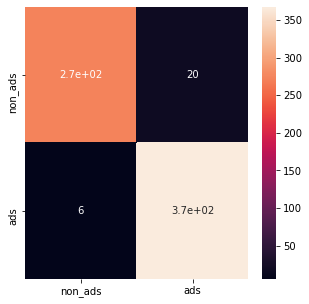

In [40]:
df_cm = pd.DataFrame(r, index = ['non_ads','ads'],
                  columns = ['non_ads','ads'])
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=True)

### 2. Using Neural Network to combines 2 phases

#### Train phase 1 using SVM

In [41]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import sklearn.metrics as metrics

In [42]:
f = []
ctpn_output_train = "../data/dataset/ctpn_output/training_data/"
for dirpath, dirnames, filenames in os.walk(ctpn_output_train):
    f.append(filenames)
    break
f = f[0]
ads_train_data = []
for name in f:
    ads_train_data.append([i[:-1] for i in open(ctpn_output_train + name,'r').readlines() if i !="\n"])

In [43]:
img_train_path = "../data/dataset/training_data/"
hw_train = [PIL.Image.open(img_train_path + "/" + name[:-3] + "png").size for name in f] 
n_att = 10
w_train = []
for bbs,hw in zip(ads_train_data,hw_train):
    if len(bbs) <n_att:
        continue
    temp_scale = []
    temp_distance = []
    for bb in bbs:
        h_b,w_b,h_cb,w_cb =extract_info(bb)
        weight = (3*h_b*(abs(h_cb-hw[1])+1)*(abs(w_cb-hw[0])+1))/w_b
        temp_scale.append(h_b/w_b)
        temp_distance.append((abs(h_cb-hw[1])+1)*(abs(w_cb-hw[0])+1)/(hw[0]*hw[1]))
    bb_t, w_t = sort_weight(bbs, temp_scale,temp_distance)
    w_train.append(w_t)


In [44]:
X_train = w_train
y_train = [0]*len(w_train)
for i in range(len(f)):
    if f[i][:3] == "ads":
        y_train[i] = 1

In [45]:
clf = SVC(C=1.0, kernel='rbf', probability=True).fit(X_train,y_train)
clf.probability = True

In [46]:
train_phase_1 =[[i[1],i[0]] for i in clf.predict_proba(X_train)]

In [47]:
train_phase_1[:10]

[[0.8571722216059422, 0.1428277783940578],
 [0.5171788587356276, 0.4828211412643723],
 [0.970337292896941, 0.02966270710305902],
 [0.547264866598037, 0.4527351334019629],
 [0.8236336530922111, 0.1763663469077892],
 [0.7968351391611713, 0.20316486083882856],
 [0.9810935711248752, 0.018906428875124694],
 [0.9465200260716699, 0.05347997392833045],
 [0.8304880406163764, 0.1695119593836236],
 [0.9304266161489487, 0.06957338385105137]]

#### Train phase 2 use Xception

In [49]:
from tensorflow.keras.models import load_model
import os
from PIL import Image
from skimage import transform
import shutil
import keras
import tensorflow as tf

In [50]:
train_phase_2 = []
for name in f:
    r =model_phase_2.predict(load(img_train_path + name[:-3] + "png"))
    train_phase_2.append([1-r[0][0], r[0][0]])

#### Save 2 file train_phase_1 and train_phase_2

In [51]:
# Save list result of phase 1 and 2
with open("./train_phase_1.pkl", "wb") as file_io:
    pickle.dump(train_phase_1,file_io)
with open("./train_phase_2.pkl", "wb") as file_io:
    pickle.dump(train_phase_2,file_io)

#### Load 2 file train_phase_1 and train_phase_2

In [52]:
# Save list result of phase 1 and 2
with open("./train_phase_1.pkl", "rb") as file_io:
    train_phase_1 = pickle.load(file_io)
with open("./train_phase_2.pkl", "rb") as file_io:
    train_phase_2 = pickle.load(file_io)

In [53]:
from keras.models import Sequential
from keras.layers import Dense

### Train Neural Network

In [54]:
X = [train_phase_1[i] + train_phase_2[i] for i in range(len(train_phase_1))]
y = y_train

In [55]:

# define the keras model
model =Sequential()
model.add(Dense(16, input_dim=4, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [56]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [57]:
model.fit(X,y,epochs=100,batch_size=10)

Epoch 1/100
156/156 [==============================] - 1s 1ms/step - loss: 0.4941 - accuracy: 0.8673
Epoch 2/100
156/156 [==============================] - 0s 997us/step - loss: 0.1959 - accuracy: 0.9762
Epoch 3/100
156/156 [==============================] - 0s 892us/step - loss: 0.0669 - accuracy: 0.9781
Epoch 4/100
156/156 [==============================] - 0s 786us/step - loss: 0.0640 - accuracy: 0.9774
Epoch 5/100
156/156 [==============================] - 0s 795us/step - loss: 0.0605 - accuracy: 0.9774
Epoch 6/100
156/156 [==============================] - 0s 945us/step - loss: 0.0611 - accuracy: 0.9749
Epoch 7/100
156/156 [==============================] - 0s 1ms/step - loss: 0.0593 - accuracy: 0.9768
Epoch 8/100
156/156 [==============================] - 0s 866us/step - loss: 0.0575 - accuracy: 0.9762
Epoch 9/100
156/156 [==============================] - 0s 856us/step - loss: 0.0574 - accuracy: 0.9774
Epoch 10/100
156/156 [==============================] - 0s 821us/step - loss:

### Evaluating NN for 2 phases

In [58]:
y_pred = model.predict([test_phase_1[i] + test_phase_2[i] for i in range(len(test_phase_1))])

In [59]:
y_pred = [1 if i >= 0.5 else 0 for i in y_pred]

In [60]:
metrics.confusion_matrix(y_test,y_pred)

array([[284,   9],
       [ 11, 362]], dtype=int64)

In [61]:
metrics.accuracy_score(y_test,y_pred)

0.96996996996997

### Using Genetic Algorithm with ANN

In [62]:
import ANN
import ga

In [63]:
X = np.array(X)
y = np.array(y)

In [64]:
X.shape

(1552, 4)

In [65]:
sol_per_pop = 15
num_parents_mating = 5
num_generations = 1000
mutation_percent = 10

C:\Users\Admin\AppData\Local\Temp/ipykernel_15248/1730476142.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  initial_pop_weights.append(np.array([input_HL1_weights,
C:\Users\Admin\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


0 Fitness
[43.94329897 43.94329897 43.94329897 56.05670103 56.05670103 56.05670103
 43.94329897 56.05670103 56.05670103 43.94329897 56.05670103 56.05670103
 43.94329897 43.94329897 43.94329897]
50 Fitness
[95.6185567  93.94329897 93.55670103 92.97680412 92.46134021 56.05670103
 43.94329897 43.94329897 43.94329897 56.05670103 56.05670103 56.05670103
 68.87886598 43.94329897 56.05670103]
100 Fitness
[98.32474227 98.26030928 98.06701031 98.06701031 98.06701031 95.16752577
 96.97164948 95.94072165 96.2628866  96.64948454 97.61597938 97.29381443
 97.55154639 93.87886598 95.74742268]
150 Fitness
[98.32474227 98.32474227 98.32474227 98.32474227 98.26030928 90.65721649
 59.14948454 38.33762887 97.68041237 98.06701031 95.81185567 94.78092784
 43.94329897 79.25257732 98.1314433 ]
200 Fitness
[98.32474227 98.32474227 98.32474227 98.32474227 98.26030928 96.97164948
 93.49226804 56.05670103 56.05670103 92.20360825 97.35824742 93.49226804
 43.94329897 54.51030928 94.32989691]
250 Fitness
[98.3247422

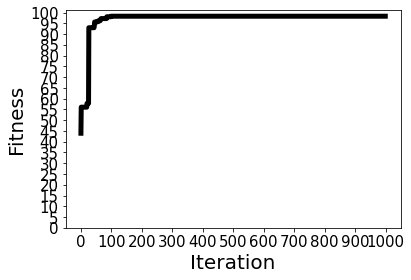

In [66]:

#Creating the initial population.
initial_pop_weights = []
for curr_sol in np.arange(0, sol_per_pop):
    HL1_neurons = 150
    input_HL1_weights = np.random.uniform(low=-0.1, high=0.1, 
                                             size=(X.shape[1], HL1_neurons))
    HL2_neurons = 60
    HL1_HL2_weights = np.random.uniform(low=-0.1, high=0.1, 
                                             size=(HL1_neurons, HL2_neurons))
    output_neurons = 2
    HL2_output_weights = np.random.uniform(low=-0.1, high=0.1, 
                                              size=(HL2_neurons, output_neurons))

    initial_pop_weights.append(np.array([input_HL1_weights, 
                                                HL1_HL2_weights, 
                                                HL2_output_weights]))

pop_weights_mat = np.array(initial_pop_weights)
pop_weights_vector = ga.mat_to_vector(pop_weights_mat)

best_outputs = []
accuracies = np.empty(shape=(num_generations))

for generation in range(num_generations):
    # print("Generation : ", generation)

    # converting the solutions from being vectors to matrices.
    pop_weights_mat = ga.vector_to_mat(pop_weights_vector, 
                                       pop_weights_mat)

    # Measuring the fitness of each chromosome in the population.
    fitness = ANN.fitness(pop_weights_mat, 
                          X, 
                          y, 
                          activation="sigmoid")
    accuracies[generation] = fitness[0]
    if generation % 50 == 0:
        print("{} Fitness".format(generation))
        print(fitness)

    # Selecting the best parents in the population for mating.
    parents = ga.select_mating_pool(pop_weights_vector, 
                                    fitness.copy(), 
                                    num_parents_mating)
    # print("Parents")
    # print(parents)

    # Generating next generation using crossover.
    offspring_crossover = ga.crossover(parents,
                                       offspring_size=(pop_weights_vector.shape[0]-parents.shape[0], pop_weights_vector.shape[1]))
    # print("Crossover")
    # print(offspring_crossover)

    # Adding some variations to the offsrping using mutation.
    offspring_mutation = ga.mutation(offspring_crossover, 
                                     mutation_percent=mutation_percent)
    # print("Mutation")
    # print(offspring_mutation)

    # Creating the new population based on the parents and offspring.
    pop_weights_vector[0:parents.shape[0], :] = parents
    pop_weights_vector[parents.shape[0]:, :] = offspring_mutation

pop_weights_mat = ga.vector_to_mat(pop_weights_vector, pop_weights_mat)
best_weights = pop_weights_mat [0, :]
acc, predictions = ANN.predict_outputs(best_weights, X, y, activation="sigmoid")
print("Accuracy of the best solution is : ", acc)

plt.plot(accuracies, linewidth=5, color="black")
plt.xlabel("Iteration", fontsize=20)
plt.ylabel("Fitness", fontsize=20)
plt.xticks(np.arange(0, num_generations+1, 100), fontsize=15)
plt.yticks(np.arange(0, 101, 5), fontsize=15)
plt.show()


In [67]:
# Save weight of GA with ANN
f = open("weights_"+str(num_generations)+"_iterations_"+str(mutation_percent)+"%_mutation.pkl", "wb")
pickle.dump(pop_weights_mat, f)
f.close()

### Evaluating Generic algorithm with ANN

In [68]:
X_ga_test = np.array([test_phase_1[i] + test_phase_2[i] for i in range(len(test_phase_1))])
y_ga_test = np.array(y_test)

In [69]:
acc, predictions = ANN.predict_outputs(best_weights, X_ga_test, y_ga_test, activation="sigmoid")

In [70]:
metrics.confusion_matrix(y_ga_test,predictions)

array([[279,  14],
       [  8, 365]], dtype=int64)

In [71]:
acc

96.69669669669669

In [79]:
with open("X.pkl", "wb") as f:
    pickle.dump(X, f)
with open("y.pkl", "wb") as f:
    pickle.dump(y, f)
with open("X_ga_test.pkl", "wb") as f:
    pickle.dump(X_ga_test, f)
with open("y_ga_test.pkl", "wb") as f:
    pickle.dump(y_ga_test, f)


### Using Genetic algorithm

In [85]:
import pickle
import pygad
import math

In [86]:
# Thêm dãy số phần tử 1 vào cuối mỗi record
one = np.ones((X.shape[0], 1))
X = np.concatenate((X,one), axis = 1)
one = np.ones((X_ga_test.shape[0], 1))
X_ga_test = np.concatenate((X_ga_test,one), axis = 1)

In [87]:
def sigmoid(x):
    """Tính sigmoid"""
    return 1/(1+math.exp(-x))

def get_test_acc(w):
    """Tính đọ chính xác của tập test"""
    store = np.zeros(X_ga_test.shape[0])
    for idx,x in enumerate(X_ga_test):
        t = w.dot(x)
        if sigmoid(t) < 0.5:
            store[idx] = 1
    acc = (store==y_ga_test).sum()/X_ga_test.shape[0]
    return acc
def get_acc(w):
    """Tính độ chính xác của tập train"""
    store = np.zeros(X.shape[0])
    for idx,x in enumerate(X):
        t = w.dot(x)
        if sigmoid(t) < 0.5:
            store[idx] = 1
    acc = (store==y).sum()/X.shape[0]
    return acc

In [88]:
def fitness_func(solution, solution_idx):
    """Định nghĩa hàm fitness, sử dụng hàm sigmoid"""
    fitness = get_acc(solution)
    return fitness

In [89]:
# Xây dựng các thông số cần thiết để chạy GA
sol_per_pop = 200
num_genes = X.shape[1]

init_range_low = -1
init_range_high = -0.5

mutation_percent_genes = 10
num_generations = 1000
num_parents_mating = 30

In [90]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating, 
                       fitness_func=fitness_func,
                       sol_per_pop=sol_per_pop, 
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       mutation_percent_genes=mutation_percent_genes)

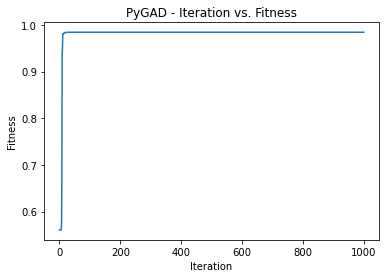

In [91]:
# Tiến hành chạy và in ra sơ đồ
ga_instance.run()
ga_instance.plot_result()

In [92]:
# In ra kết quả của GA
solution, solution_fitness = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Parameters of the best solution : [-0.1369321   0.08634833 -0.33926826  4.84338126 -0.01599282  0.17770941]
Fitness value of the best solution = 0.9845360824742269


In [93]:
get_test_acc(solution)

0.9669669669669669